## Parking Lot Classifier

### Importing Necessary Libraries

In [4]:
# Basic Libraries
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

### Check Graphics Card

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13274716543524158291
xla_global_id: -1
]


In [6]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available: 0


In [7]:
print(tf.__version__)

2.19.0


In [8]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Apr_17_19:36:51_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.5, V12.5.40
Build cuda_12.5.r12.5/compiler.34177558_0


In [9]:
print("cuDNN version:", tf.sysconfig.get_build_info().get("cudnn_version"))

cuDNN version: None


### Data Extraction

In [10]:

dataset_path = "parking/clf-data"

In [11]:
# # Verify the dataset path and structure
# print("Dataset path:", dataset_path)
# print("Contents of dataset_path:", os.listdir(dataset_path))

In [12]:
# train_dir = os.path.join(dataset_path, 'train')
# validation_dir = os.path.join(dataset_path, 'validation')

In [13]:
# # Verify train and validation directories
# print("Train directory contents:", os.listdir(train_dir))
# print("Validation directory contents:", os.listdir(validation_dir))

### Creating TensorFlow Data Oject & Visualizing the Dataset



In [14]:
# Batch sizes are usually in powers of 2: 32, 64, 128, 256, etc.
batch_size = 32

# MobileNetV2 model expects input images to be 160 x 160 pixels
# But usually powers of 2 are used for image size: 128 x 128 or 256 x 256
img_size = (160, 160)

In [15]:
# # Verify train and validation directories
# print("Train directory contents:", os.listdir(train_dir))
# print("Validation directory contents:", os.listdir(validation_dir))

### Train-Test Split


In [16]:
# Define a function to resize with padding
def resize_with_padding(image, label):
    image = tf.image.resize_with_pad(image, 160, 160)
    return image, label

In [17]:
# Load datasets
train_dataset_raw = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=True,
    image_size=(29, 69),
    batch_size=batch_size
)

validation_dataset_raw = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    image_size=(29, 69),
    batch_size=batch_size
)

# Get class names before mapping
class_names = train_dataset_raw.class_names
print("Class names:", class_names)

# Then map (resize with padding)
train_dataset = train_dataset_raw.map(resize_with_padding)
validation_dataset = validation_dataset_raw.map(resize_with_padding)


Found 6090 files belonging to 2 classes.
Using 4872 files for training.
Found 6090 files belonging to 2 classes.
Using 1218 files for validation.
Class names: ['empty', 'not_empty']


In [18]:
# Apply it to both datasets
train_dataset = train_dataset.map(resize_with_padding)
validation_dataset = validation_dataset.map(resize_with_padding)

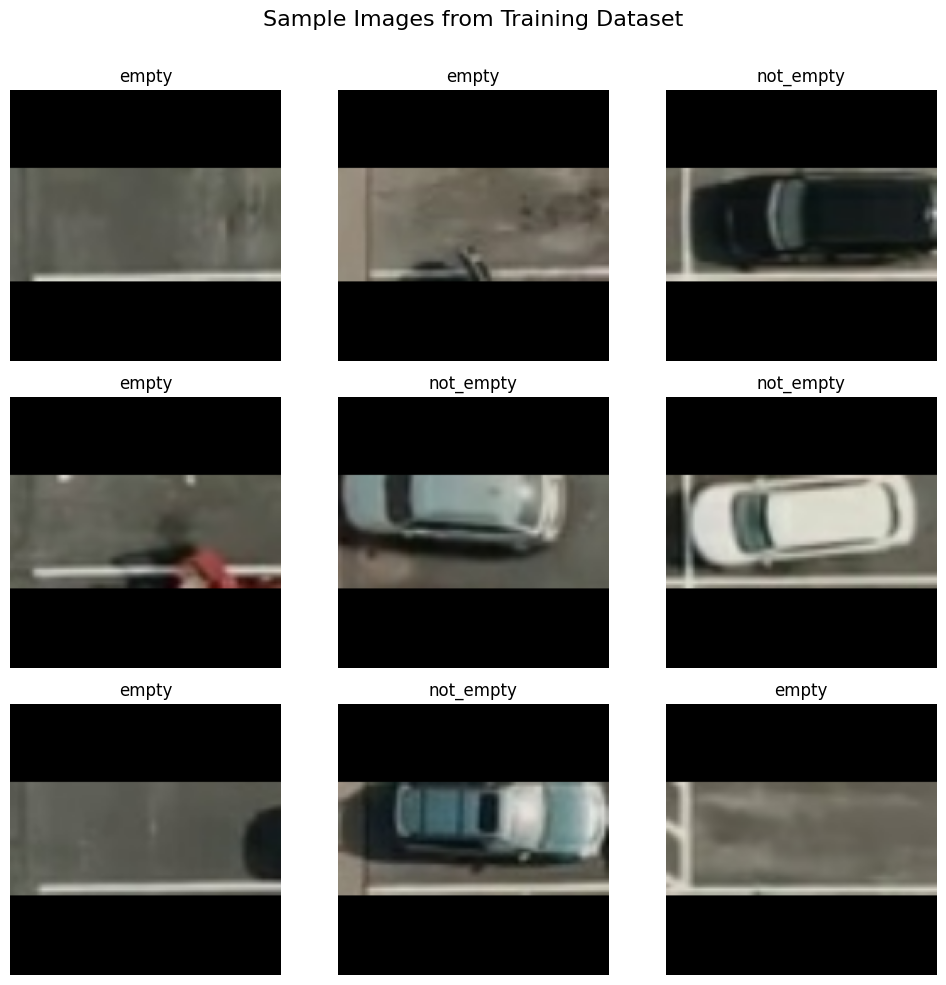

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Sample Images from Training Dataset", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Preprocessing the Dataset 


#### Test & Validation Datasets

In [20]:
# # Split validation set into validation and test datasets
val_batches = tf.data.experimental.cardinality(validation_dataset)

# val_vatches object is a tensor, so we need to convert it to a number

In [21]:
int(val_batches)

39

In [22]:
test_dataset = validation_dataset.take(val_batches // 5) # val_batches // 5 is 20% of the validation dataset
validation_dataset = validation_dataset.skip(val_batches // 5) # 80% of the validation dataset

In [23]:
print('Number of validation batches:', tf.data.experimental.cardinality(validation_dataset).numpy())
print('Number of test batches:', tf.data.experimental.cardinality(test_dataset).numpy())

Number of validation batches: 32
Number of test batches: 7


#### Prefetching for optimization

Prefetching overlaps data preparation with model execution, ensuring the training process remains efficient.

The `prefetch(buffer_size=AUTOTUNE)` function preloads batches while the model processes the current batch.

Using `AUTOTUNE` allows TensorFlow to dynamically determine the optimal buffer size for the system.

In [24]:
tf.data.AUTOTUNE

-1

In [25]:
autotune = tf.data.AUTOTUNE

In [26]:
# Optimize dataset performance with prefetching
train_dataset = train_dataset.prefetch(buffer_size=autotune)
validation_dataset = validation_dataset.prefetch(buffer_size=autotune)
test_dataset = test_dataset.prefetch(buffer_size=autotune)

### Data Augmentation

In [27]:
# Data Augmentation
horizontal_flips = tf.keras.layers.RandomFlip('horizontal')
radians = tf.keras.layers.RandomRotation(0.02)

In [28]:
data_augmentation = tf.keras.Sequential([
    horizontal_flips,
    radians
])

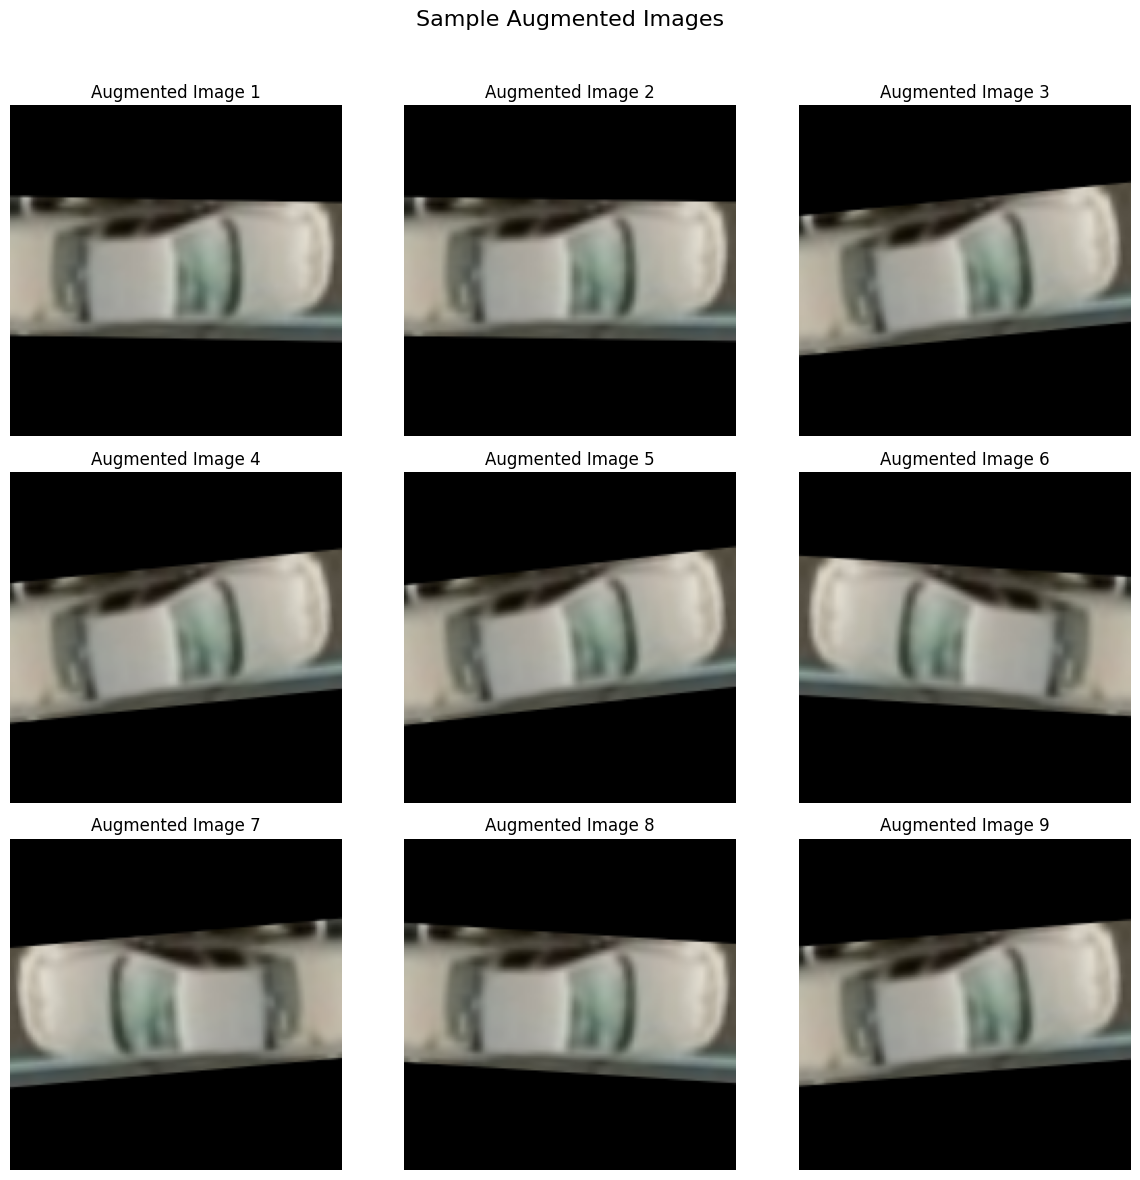

In [29]:
# Visualize augmented images
plt.figure(figsize=(12, 12))
for images, _ in train_dataset.take(1):
    sample_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(f"Augmented Image {i+1}", fontsize=12)
plt.suptitle("Sample Augmented Images", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Transfer Learning with MobileNetV2



In [30]:
img_shape = img_size + (3,)

In [31]:
img_size

(160, 160)

In [32]:
img_shape

(160, 160, 3)

#### CNN Architecture

In [33]:
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape, 
                                               include_top=False, # Exclude the ImageNet classifier at the top
                                               weights='imagenet') # Use the pre-trained weights from ImageNet

In [34]:
base_model.trainable = False # Freeze the base model to keep the pre-trained weights

#### MobileNetV2 Structure

In [35]:
inputs = tf.keras.Input(shape=img_shape)
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)

#### Last Layers

In [36]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # layer object

# Apply the layer to MobileNetV2
x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.2)(x) ### Optional: Add a dropout layer

prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid') # layer object
# Apply Fully Connected Layer to predict the class
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [37]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### Training the Model


In [38]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=batch_size, # Learning rate will decrease every batch
    decay_rate=0.8 # rate of decrease means 90% of the learning rate is decreased
)

In [39]:
# Compile the model structure for training
base_learning_rate = 0.1
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), # Adam deals with gradient descent
              loss=tf.keras.losses.BinaryCrossentropy(), # measures the difference between two probability distributions
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]) # calculates how often predictions match binary labels

#### Early Stop, Epochs & Saving the Best Model

In [40]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [41]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)

In [42]:
# Epochs are the number of times the model will see the entire dataset
# Start with a small number of epochs to prevent overfitting
# Epochs usually are in the range of 10 to 100. Standard is up to 50.
initial_epochs = 50

#### Training & Saving (Best Model + Metrics)

In [43]:
import json

# Train the model with callbacks
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset,
    callbacks=[early_stopping, model_checkpoint], # Callbacks are used to customize the training process
    verbose=1  # Verbosity level: 1 = progress bar, 2 = one line per epoch
)

# Save training history
with open('training_history.json', 'w') as file: # open creates a file
    json.dump(history.history, file) # dump saves it as a json file

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 53s 319ms/step - accuracy: 0.9068 - loss: 1.3896 - val_accuracy: 0.9930 - val_loss: 0.0828
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 42s 271ms/step - accuracy: 0.9958 - loss: 0.0277 - val_accuracy: 0.9920 - val_loss: 0.0450
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 41s 266ms/step - accuracy: 0.9981 - loss: 0.0079 - val_accuracy: 0.9930 - val_loss: 0.0445
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 41s 269ms/step - accuracy: 0.9998 - loss: 0.0014 - val_accuracy: 0.9920 - val_loss: 0.0440
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 41s 268ms/step - accuracy: 0.9983 - loss: 0.0064 - val_accuracy: 0.9920 - val_loss: 0.0448
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 41s 266ms/step - accuracy: 0.9997 - loss: 0.0035 - val_accuracy: 0.9920 - val_loss: 0.0444
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 40s 262ms/step - accuracy: 0.9990 - loss: 0.0076 - val_accuracy: 0.9920 - val_loss: 0.0438
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 41s 266ms/step - accuracy: 0.9989 - loss: 0

### Fine-Tuning the Model


In [44]:
# Unfreeze some layers for fine-tuning
base_model.trainable = True

#### Freeze the first 100 layers

In [45]:
len(base_model.layers)

154

In [46]:
for layer in base_model.layers[:100]: # Freeze the first 100 layers
    layer.trainable = False

In [47]:
base_learning_rate
fine_tune_learning_rate = base_learning_rate / 10 # 10 times smaller learning rate for fine-tuning

In [48]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_learning_rate),  # Smaller learning rate
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]
)

In [49]:
# Same callbacks
fine_tune_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
fine_tune_model_checkpoint = ModelCheckpoint(filepath='fine_tuned_model.keras', monitor='val_loss', save_best_only=True)


# Define fine-tuning epochs
fine_tune_epochs = 50
total_epochs = initial_epochs + fine_tune_epochs

In [50]:
# Fine-tune the model
history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],  # Continue from where the initial training ended
    validation_data=validation_dataset,
    callbacks=[fine_tune_early_stopping, fine_tune_model_checkpoint],  # Add callbacks
    verbose=1
)

# Save fine-tuning history
with open('fine_tuning_history.json', 'w') as file:
    json.dump(history_fine.history, file)

Epoch 38/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 72s 399ms/step - accuracy: 0.9134 - loss: 0.8452 - val_accuracy: 0.5131 - val_loss: 327.3154
Epoch 39/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 63s 410ms/step - accuracy: 0.9974 - loss: 0.0165 - val_accuracy: 0.5211 - val_loss: 210.2824
Epoch 40/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 69s 448ms/step - accuracy: 0.9996 - loss: 0.0013 - val_accuracy: 0.8541 - val_loss: 19.8094
Epoch 41/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 60s 393ms/step - accuracy: 1.0000 - loss: 7.1069e-04 - val_accuracy: 0.9759 - val_loss: 4.2365
Epoch 42/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 65s 424ms/step - accuracy: 1.0000 - loss: 1.4849e-04 - val_accuracy: 0.9406 - val_loss: 5.3288
Epoch 43/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 70s 457ms/step - accuracy: 1.0000 - loss: 5.6364e-06 - val_accuracy: 0.9195 - val_loss: 5.6423
Epoch 44/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 67s 437ms/step - accuracy: 1.0000 - loss: 2.4815e-05 - val_accuracy: 0.8672 - val_loss: 5.1076
Epoch 45/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 68s 44

### Evaluating and Visualizing Results

In [51]:
# Using the best model
model = tf.keras.models.load_model('fine_tuned_model.keras')

In [52]:
# Evaluate the fine-tuned model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - accuracy: 0.9785 - loss: 4.7797


In [53]:
# Load training history
with open('training_history.json', 'r') as file:
    training_history = json.load(file)

# Load fine-tuning history
with open('fine_tuning_history.json', 'r') as file:
    fine_tuning_history = json.load(file)

In [54]:
# Combine training and fine-tuning metrics
acc = training_history['accuracy'] + fine_tuning_history['accuracy']
val_acc = training_history['val_accuracy'] + fine_tuning_history['val_accuracy']

loss = training_history['loss'] + fine_tuning_history['loss']
val_loss = training_history['val_loss'] + fine_tuning_history['val_loss']

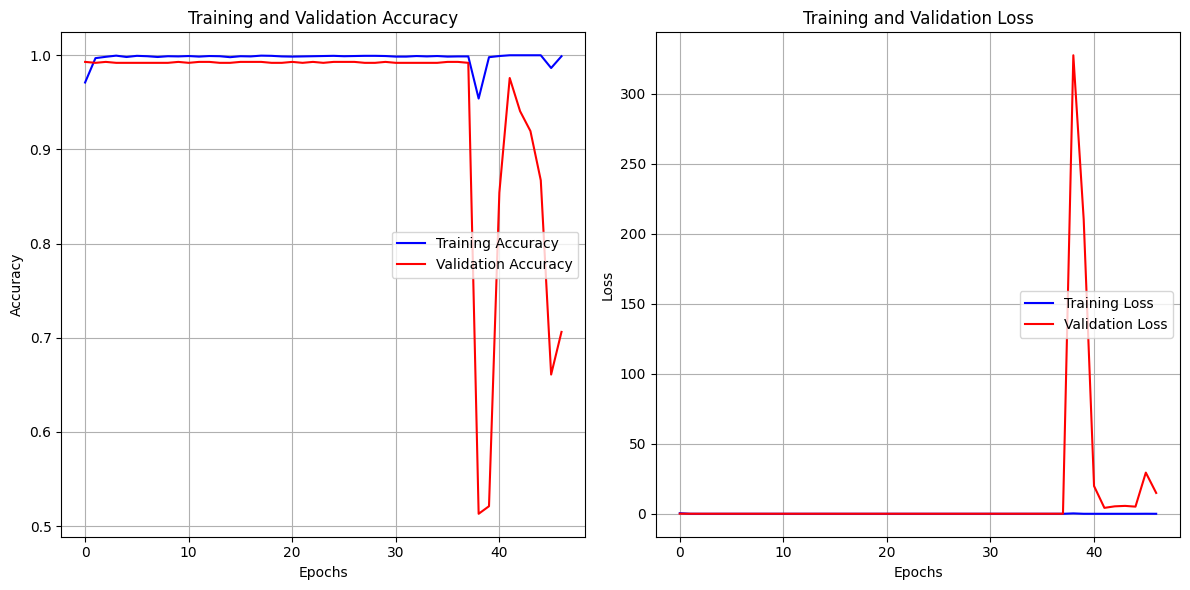

In [64]:
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='red')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.5))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()


In [56]:
# Gather ground truth and predictions from the test dataset
ground_truth = np.concatenate([labels.numpy() for _, labels in test_dataset]) 

#predictions = np.concatenate([tf.where(model(X).numpy().flatten() < 0.5, 0, 1).numpy() for X, _ in test_dataset])


In [57]:
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images).flatten()
    bin_preds = (predictions > 0.5).astype("int32")

    y_true.extend(labels.numpy())
    y_pred.extend(bin_preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

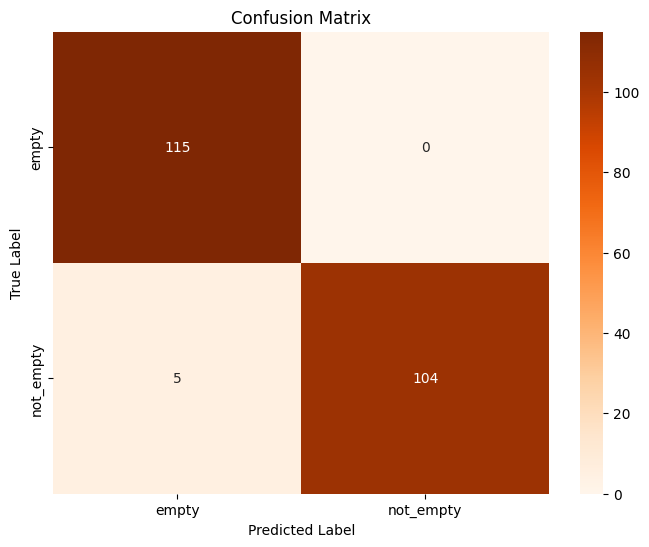

In [59]:
# Compute confusion a
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Oranges", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [60]:
from sklearn.metrics import classification_report

In [61]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

       empty       0.96      1.00      0.98       115
   not_empty       1.00      0.95      0.98       109

    accuracy                           0.98       224
   macro avg       0.98      0.98      0.98       224
weighted avg       0.98      0.98      0.98       224



In [62]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

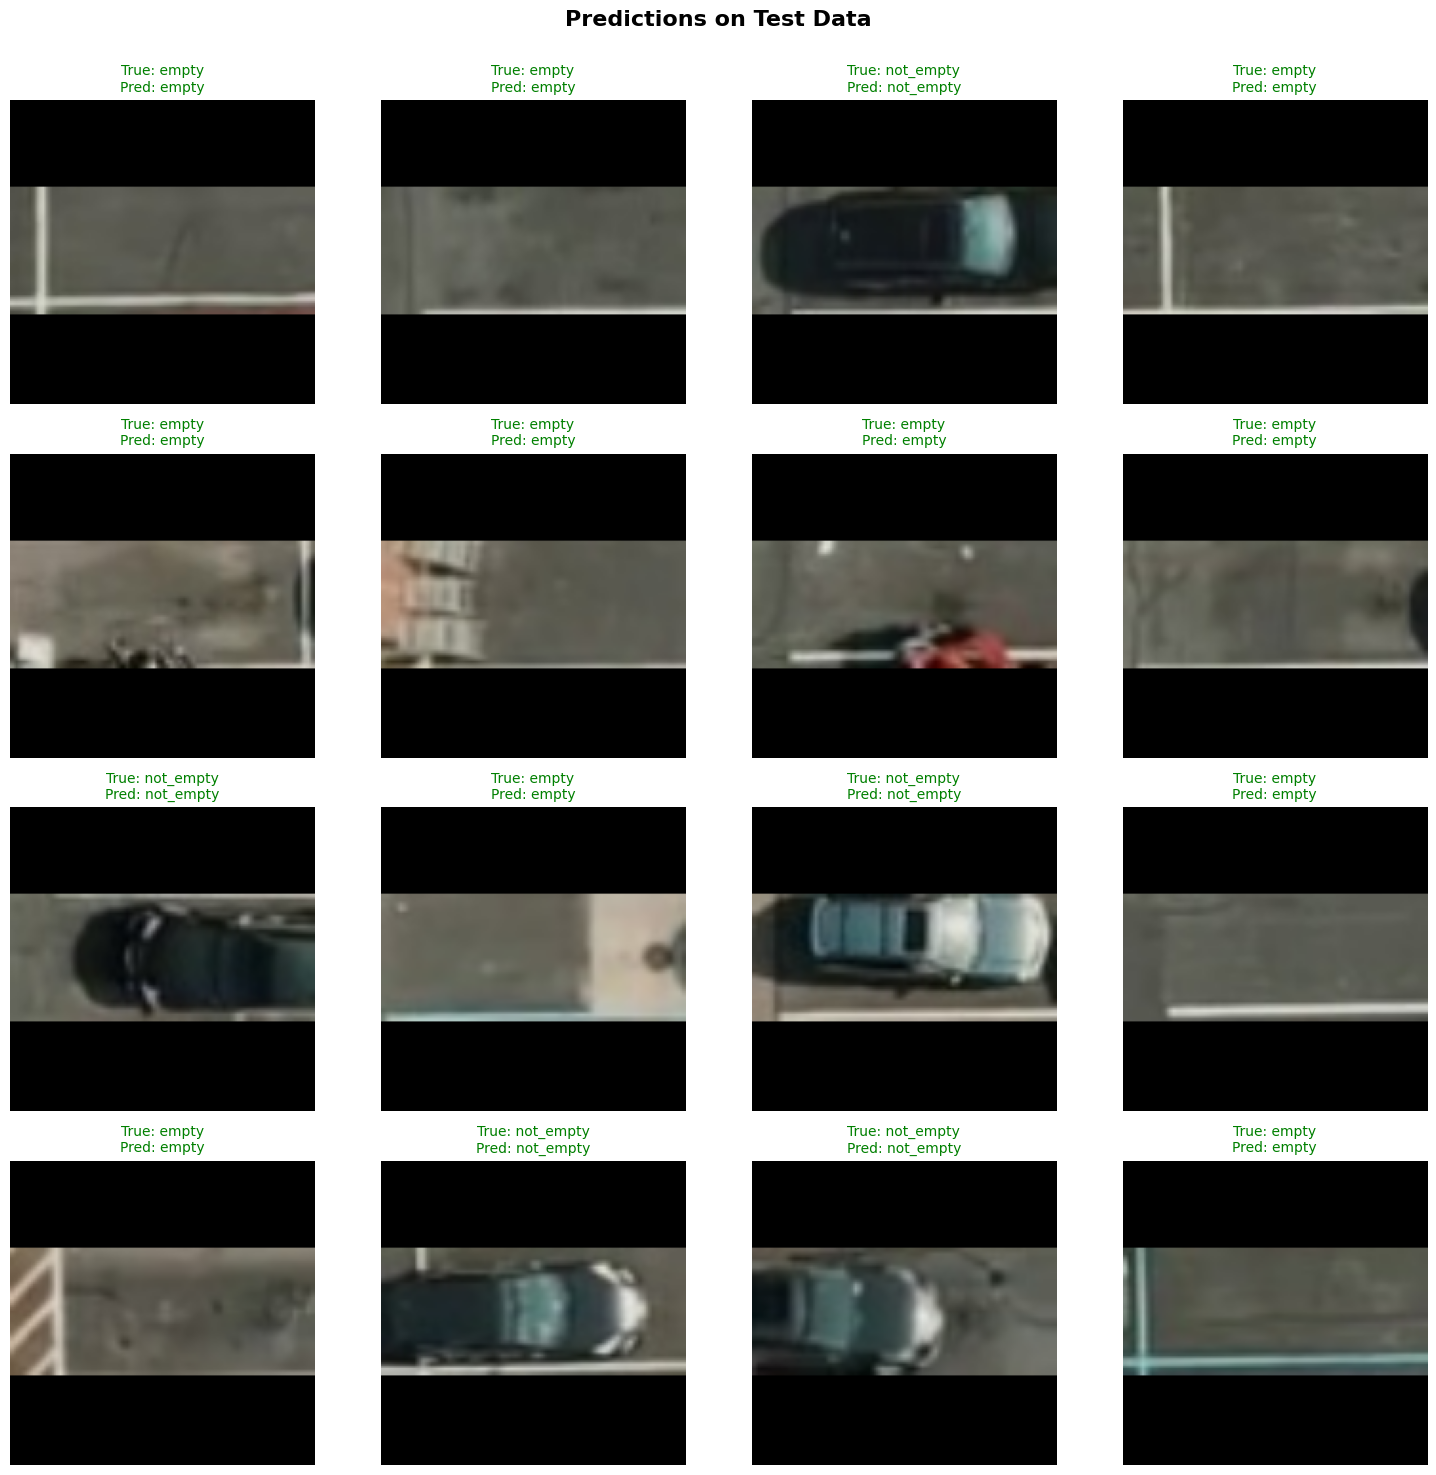

In [92]:
# Get a batch of test data
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

# Generate predictions
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1).numpy()  # Apply threshold for binary classification

# Visualize predictions
plt.figure(figsize=(15, 15))
for i in range(16):  # Increase the number of images to 16
    ax = plt.subplot(4, 4, i + 1)  # Adjust the grid to 4x4
    plt.imshow(image_batch[i].astype("uint8"))
    true_label = label_batch[i]
    pred_label = predictions[i]
    title = f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}"
    color = 'green' if true_label == pred_label else 'red'
    plt.title(title, color=color, fontsize=10)  # Make the font size smaller
    plt.axis("off")
plt.suptitle("Predictions on Test Data", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

## Video Prediction

#### Split image

In [141]:
import cv2
import os

# Paths
video_path = "parking/parking_1920_1080.mp4"
mask_path = "parking/mask_1920_1080.png"
output_base = "video_analysis"

print("Video exists:", os.path.exists(video_path))

# Create output base directory if it doesn't exist
os.makedirs(output_base, exist_ok=True)

# Load video and mask
cap = cv2.VideoCapture(video_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Threshold mask to binary
_, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

# Find contours (each represents a parking spot)
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Found {len(contours)} parking spots.")

frame_idx = 0        # Index of current frame
sample_num = 0       # Index of sample we save (every 100th frame)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_idx % 50 == 0:
        print(f"Processing frame {frame_idx}")

        # Create output folder for this sampled frame
        frame_folder = os.path.join(output_base, f"frame_{frame_idx}")
        os.makedirs(frame_folder, exist_ok=True)

        for i, cnt in enumerate(contours):
            x, y, w, h = cv2.boundingRect(cnt)
            crop = frame[y:y+h, x:x+w]
            crop_path = os.path.join(frame_folder, f"img_{i}.jpg")
            cv2.imwrite(crop_path, crop)

        sample_num += 1

    frame_idx += 1

cap.release()
print("✅ Finished processing sampled frames.")


Video exists: True
Found 396 parking spots.
Processing frame 0
Processing frame 50
Processing frame 100
Processing frame 150
Processing frame 200
Processing frame 250
Processing frame 300
Processing frame 350
Processing frame 400
Processing frame 450
Processing frame 500
Processing frame 550
Processing frame 600
Processing frame 650
Processing frame 700
Processing frame 750
Processing frame 800
✅ Finished processing sampled frames.


#### Resize

In [142]:
import tensorflow as tf
import os

# Your resize function
def resize_with_padding(image, label):
    image = tf.image.resize_with_pad(image, 160, 160)
    return image, label

# Base directory
base_folder = "video_analysis"
dummy_label = 0  # Replace if you have actual labels

# This will store your resized tensors
resized_images_per_frame = {}

# Find all frame folders like frame_0, frame_100, ...
frame_folders = [
    d for d in os.listdir(base_folder)
    if os.path.isdir(os.path.join(base_folder, d)) and d.startswith("frame_")
]

# Sort by frame number (e.g., "frame_0", "frame_100", etc.)
frame_folders = sorted(frame_folders, key=lambda x: int(x.split("_")[1]))

for frame_folder in frame_folders:
    full_path = os.path.join(base_folder, frame_folder)
    frame_num = int(frame_folder.split("_")[1])

    if not os.path.exists(full_path):
        print(f"Skipping missing folder: {full_path}")
        continue

    # Sorted list of images like img_0.jpg, img_1.jpg, ...
    image_paths = sorted(
        [os.path.join(full_path, f) for f in os.listdir(full_path) if f.endswith(".jpg")],
        key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split("_")[1])
    )

    resized_images = []

    for img_path in image_paths:
        img_raw = tf.io.read_file(img_path)
        img_tensor = tf.image.decode_jpeg(img_raw, channels=3)
        img_tensor, _ = resize_with_padding(img_tensor, dummy_label)
        resized_images.append(img_tensor)

    resized_images_per_frame[frame_num] = resized_images
    print(f"✅ Processed {frame_folder} with {len(resized_images)} images.")


✅ Processed frame_0 with 396 images.
✅ Processed frame_50 with 396 images.
✅ Processed frame_100 with 396 images.
✅ Processed frame_150 with 396 images.
✅ Processed frame_200 with 396 images.
✅ Processed frame_250 with 396 images.
✅ Processed frame_300 with 396 images.
✅ Processed frame_350 with 396 images.
✅ Processed frame_400 with 396 images.
✅ Processed frame_450 with 396 images.
✅ Processed frame_500 with 396 images.
✅ Processed frame_550 with 396 images.
✅ Processed frame_600 with 396 images.
✅ Processed frame_650 with 396 images.
✅ Processed frame_700 with 396 images.
✅ Processed frame_750 with 396 images.
✅ Processed frame_800 with 396 images.


#### Prediction test (not needed in the end)

In [143]:
predictions_per_frame = {}

sorted_frame_nums = sorted(resized_images_per_frame.keys())

for frame_num in sorted_frame_nums:
    images = resized_images_per_frame[frame_num]
    print(f"Classifying frame {frame_num}...")

    # Convert to batch tensor
    image_batch = tf.stack(images)

    # Get predictions
    preds = model.predict(image_batch, verbose=0)

    #predictions = model.predict(images).flatten()
    bin_preds = (preds > 0.5).astype("int32").flatten().tolist()

    predictions_per_frame[frame_num] = bin_preds
    print(f"Predictions for frame {frame_num}: {bin_preds}")


if frame_num == 0:

        # Visualize predictions
    plt.figure(figsize=(15, 15))

    
    for i in range(16):  # Increase the number of images to 16
        ax = plt.subplot(4, 4, i + 1)  # Adjust the grid to 4x4

        image = images[i].numpy().astype("uint8")
        pred_label = bin_preds[i]
        ax.imshow(image)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


Classifying frame 0...
Predictions for frame 0: [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

#### Write to video

In [144]:
import cv2
import tensorflow as tf
import numpy as np
import os

# Setup
video_path = "parking/parking_1920_1080.mp4"
mask_path = "parking/mask_1920_1080.png"
output_path = os.path.join("video_analysis", "annotated_output.mp4")

# Reopen original video
cap = cv2.VideoCapture(video_path)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Output video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Load contours from mask (unsorted!)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
_, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Define colors
green = (0, 255, 0)
red = (0, 0, 255)

# Go through all frames
frame_idx = 0
predictions_per_frame = {}
frame_keys = sorted(resized_images_per_frame.keys())

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_idx in resized_images_per_frame:
        print(f"Processing and classifying frame {frame_idx}")

        # Get batch of resized crops
        images = resized_images_per_frame[frame_idx]
        image_batch = tf.stack(images)

        # Predict
        preds = model.predict(image_batch, verbose=0)
        bin_preds = (preds > 0.5).astype("int32").flatten().tolist()
        predictions_per_frame[frame_idx] = bin_preds

        # Draw polygons using original contour order
        for i, cnt in enumerate(contours):
            if i >= len(bin_preds):
                continue

            color = green if bin_preds[i] == 0 else red

            overlay = frame.copy()
            cv2.drawContours(overlay, [cnt], -1, color, thickness=cv2.FILLED)
            frame = cv2.addWeighted(overlay, 0.4, frame, 0.6, 0)
            cv2.drawContours(frame, [cnt], -1, color, thickness=2)

    out.write(frame)
    frame_idx += 1

cap.release()
out.release()
print(f"✅ Annotated video saved to: {output_path}")


Processing and classifying frame 0
Processing and classifying frame 50
Processing and classifying frame 100
Processing and classifying frame 150
Processing and classifying frame 200
Processing and classifying frame 250
Processing and classifying frame 300
Processing and classifying frame 350
Processing and classifying frame 400
Processing and classifying frame 450
Processing and classifying frame 500
Processing and classifying frame 550
Processing and classifying frame 600
Processing and classifying frame 650
Processing and classifying frame 700
Processing and classifying frame 750
Processing and classifying frame 800
✅ Annotated video saved to: video_analysis\annotated_output.mp4


In [145]:
import cv2
import tensorflow as tf
import numpy as np
import os

# Paths
video_path = "parking/parking_1920_1080.mp4"
mask_path = "parking/mask_1920_1080.png"
output_path = os.path.join("video_analysis", "annotated_output.mp4")

# Reopen video
cap = cv2.VideoCapture(video_path)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Output writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Load and get contours (don't sort to preserve order!)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
_, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Colors
green = (0, 255, 0)
red = (0, 0, 255)

# Setup
frame_idx = 0
predictions_per_frame = {}
frame_keys = sorted(resized_images_per_frame.keys())
frame_keys_set = set(frame_keys)
last_bin_preds = None  # Store most recent predictions

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_idx in frame_keys_set:
        print(f"Predicting frame {frame_idx}...")

        # Predict on current frame
        images = resized_images_per_frame[frame_idx]
        image_batch = tf.stack(images)
        preds = model.predict(image_batch, verbose=0)
        bin_preds = (preds > 0.5).astype("int32").flatten().tolist()

        predictions_per_frame[frame_idx] = bin_preds
        last_bin_preds = bin_preds  # Update the most recent prediction

    # Draw polygons using last known prediction (if any)
    if last_bin_preds is not None:
        for i, cnt in enumerate(contours):
            if i >= len(last_bin_preds):
                continue
            color = green if last_bin_preds[i] == 0 else red

            overlay = frame.copy()
            cv2.drawContours(overlay, [cnt], -1, color, thickness=cv2.FILLED)
            frame = cv2.addWeighted(overlay, 0.4, frame, 0.6, 0)
            cv2.drawContours(frame, [cnt], -1, color, thickness=2)

    out.write(frame)
    frame_idx += 1

cap.release()
out.release()
print(f"✅ Annotated video saved to: {output_path}")


Predicting frame 0...
Predicting frame 50...
Predicting frame 100...
Predicting frame 150...
Predicting frame 200...
Predicting frame 250...
Predicting frame 300...
Predicting frame 350...
Predicting frame 400...
Predicting frame 450...
Predicting frame 500...
Predicting frame 550...
Predicting frame 600...
Predicting frame 650...
Predicting frame 700...
Predicting frame 750...
Predicting frame 800...
✅ Annotated video saved to: video_analysis\annotated_output.mp4
